# Unsupervised Classification of Sentinel-2 Satellite Images

Author: **Marcin Sikorski**<br>
Date: October, 2024

Clustering or unsupervised classification is the process of grouping or aggregating the pixel values of an image into a certain number of natural classes (groups) based on statistical similarity. It involves sorting observations into groups without any prior idea about what the groups are. These groups are categorized so that members of a group should be more similar to one another than they are to members of a different group. Each group is referred to as a cluster. Unsupervised classification satellite imagery is useful for:
* cloud or anomaly detection,
* data/raster compression,
* semi-supervised learning.

This notebook will show an example of satellite image clustering. We will perform this with k-means algorithm which is widely used in remote sensing and GIS.

**Notebook Content:**
1. Loading and Preprocessing Raster
2. Training K-Means Clustering Model
3. Evaluating Clusterer

### 1. Loading and Preprocessing Raster

We will setup the environment by loading the modules and raster from Sentinel-2 mission. The GeoTIFF file has been extracted from Google's Earth Engine. The area of interest will be among river Narew near the towns Wieliszew and Jachranka located in Poland. This image needs manipulation steps for further model training.

In [1]:
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# open TIF image and print metadata
# Sentinel-2 sensor delivers 13 spectral bands (Python numbers from 0)
train_raster = rio.open('Sentinel2_Narew.tif')
train_raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 1698,
 'height': 881,
 'count': 12,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841195215e-05, 0.0, 20.899484748097493,
        0.0, -8.983152841195215e-05, 52.50131812813814)}

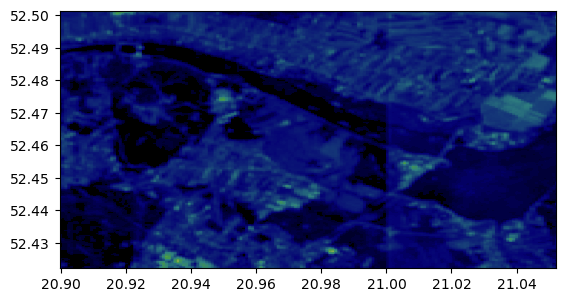

In [3]:
from rasterio.plot import show

# read image
train_arr = train_raster.read()

# 5-95% contrast stretch (enhance image)
vmin, vmax = np.nanpercentile(train_arr, (5, 95))  

show(train_raster, cmap='gist_earth', vmin=vmin, vmax=vmax)
plt.show()

In [4]:
train_stack = train_raster.read()

# convert to array
train_xyb = np.dstack(train_stack)

print('Height:', train_xyb.shape[0])
print('Width:', train_xyb.shape[1])
print('Bands:', train_xyb.shape[2])

Height: 881
Width: 1698
Bands: 12


In [5]:
# convert to vector (1D array)
bands = train_xyb.shape[2]
img_vector = train_xyb[:, :, :bands].reshape((train_xyb.shape[0] * train_xyb.shape[1], train_xyb.shape[2]))

print('Shape:', img_vector.shape)

Shape: (1495938, 12)


### 2. Training K-Means Clustering Model

K-means is probably the most widely used approach to cluster a dataset and is easy to understand. It basically divides *n* observations (pixels values in our case) into *k* clusters (number of classes predefined by user) where each observation is reassigned to the cluster with the closest mean. It is also generally considered to be memory-efficient; we need to keep in mind that satellite images tend to be very large. In our case, the clusters (or more specifically, statistical similarities) are categorized based on spectral values in each raster's pixel.

The most important parameter to set is the number of clusters. We can determine it visually from the image based on terrain type. Manual inspection is prone to error and some study areas might have very variate land cover. We will find the number of clusters with model inertias (elbow method) and Davies-Bouldin indices. Other parameters (number of maximum number iterations, number of initialization, etc.) will be left to default settings.

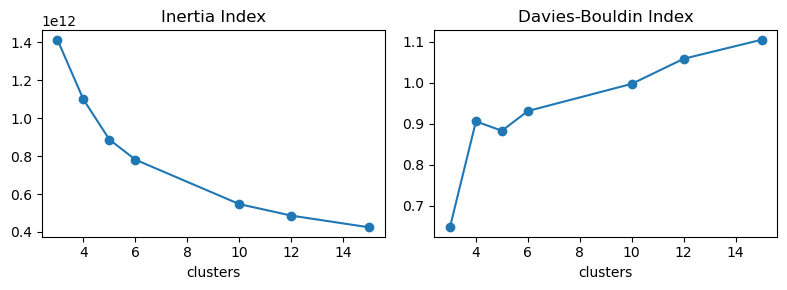

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# lists for scores
inertias = []
dav_bould_idx = []

# loop through each k value
for k in [3, 4, 5, 6, 10, 12, 15]:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(img_vector)
    
    inertias.append(kmeans.inertia_)
    dav_bould_idx.append(davies_bouldin_score(img_vector, kmeans.labels_))

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].plot([3, 4, 5, 6, 10, 12, 15], inertias, marker='o')
axes[0].set(title='Inertia Index', xlabel='clusters')

axes[1].plot([3, 4, 5, 6, 10, 12, 15], dav_bould_idx, marker='o')
axes[1].set(title='Davies-Bouldin Index', xlabel='clusters')

plt.tight_layout()
plt.show()

Both plots indicate **five clusters** to be the best option.

In [7]:
# train and fit k-means
model = KMeans(n_clusters=5)
params = model.fit(img_vector)

# get the labels of the classes
img_clusters = model.labels_

# reshape labels to a 3D array (one band only)
img_clusters = img_clusters.reshape(train_xyb[:, :, 0].shape)

print('Image shape:', img_clusters.shape)

Image shape: (881, 1698)


In [8]:
# unique labels
np.unique(params.labels_)

array([0, 1, 2, 3, 4])

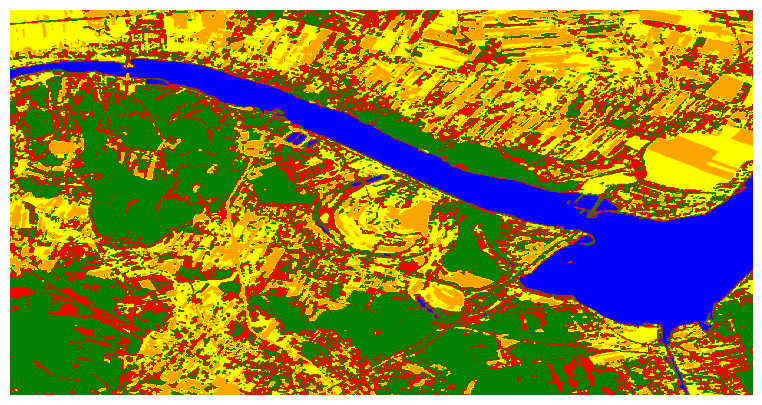

In [9]:
from matplotlib.colors import LinearSegmentedColormap

# colors for the colormap
colors = ['blue', 'red', 'green', 'yellow', 'orange']

# custom colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# display clustered image
plt.figure(figsize=(10, 5))
plt.imshow(img_clusters, cmap=custom_cmap)
plt.axis('off')
plt.show()

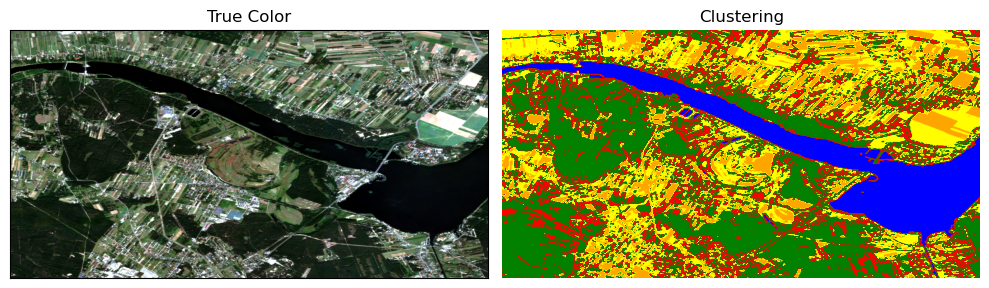

In [10]:
from pyrsgis import raster
import earthpy.plot as ep

ds, features = raster.read('Sentinel2_Narew.tif', bands='all')

# compare original and clustered image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1 = ep.plot_rgb(features, rgb=(3, 2, 1), ax=ax1, stretch=True, title='True Color')
ax2 = plt.imshow(img_clusters, cmap=custom_cmap)
plt.title('Clustering')
plt.axis('off')

plt.tight_layout()
plt.show()

By comparing the original raster with the clustering results we can notice quite high accuracy in regionalization. Especially in reservoirs and forests. We notice the predominance of agricultural and rural areas.

### 3. Evaluating Clusterer

Once the model is trained, it can be used to predict the same learned clusters in any unseen image. We will use an image adjacent to this area to predict the same classes on it. Using this clusterer in a foreign area will return inaccurate labels.

To perform clustering on a new testing raster, we will repeat all the prepocessing steps that have been implemented for the previous image (reshaping to desired arrays). We should expect similar land cover in the new clustered image.

In [11]:
# open the testing image
test_raster = rio.open('Sentinel_test.tif')
test_stack = test_raster.read()

# convert to array
test_xyb = np.dstack(test_stack)

print('Image shape:', test_xyb.shape)
    
# convert to 1D array
test_1d = test_xyb[:, :, :12].reshape(test_xyb.shape[0] * test_xyb.shape[1], test_xyb.shape[2])

# predict the clusters in the testing image 
pred = model.predict(test_1d)

# reshape labels to a 3D array (one band only)
test_clusters = pred.reshape(test_xyb[:, :, 0].shape)

Image shape: (1051, 2760, 12)


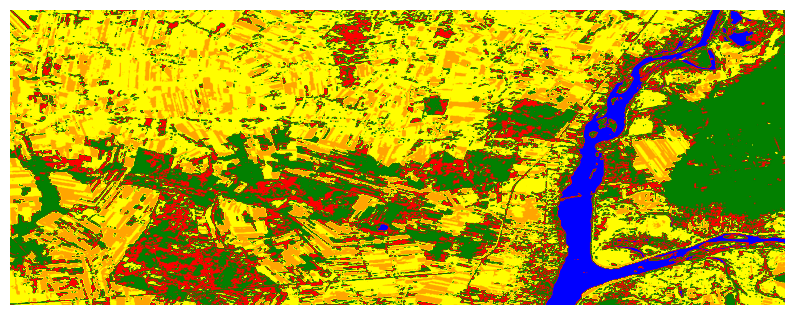

In [12]:
# display clustered image
plt.figure(figsize=(10, 7))
plt.imshow(test_clusters, cmap=custom_cmap)
plt.axis('off')
plt.show()

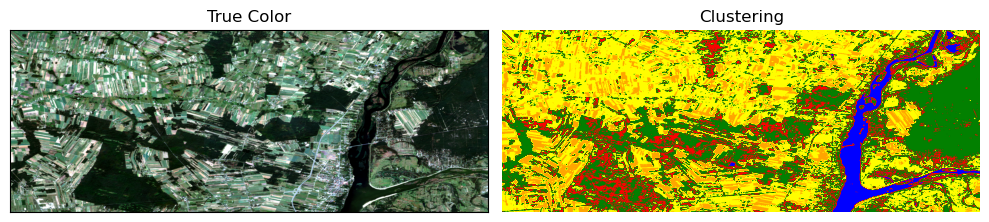

In [13]:
ds, features = raster.read('Sentinel2_test.tif', bands='all')

# compare original to clustered image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))

ax1 = ep.plot_rgb(features, rgb=(3, 2, 1), ax=ax1, stretch=True, title='True Color')
ax2 = plt.imshow(test_clusters, cmap=custom_cmap)
plt.title('Clustering')
plt.axis('off')

plt.tight_layout()
plt.show()

The second, adjacent image has been clustered properly and the terrain types seem to match each other. This k-means model works well on remotely sensed data of this geographic region.

**References:**
1. https://geographicdata.science/book/notebooks/10_clustering_and_regionalization.html [Accessed: 28.10.2024]
2. https://ml-gis-service.com/index.php/2020/10/14/data-science-unsupervised-classification-of-satellite-images-with-k-means-algorithm/ [Accessed: 28.10.2024]